## DiffPool Model

In [1]:
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.loader import DenseDataLoader #To make use of this data loader, all graph attributes in the dataset need to have the same shape. In particular, this data loader should only be used when working with dense adjacency matrices.
from torch_geometric.nn import DenseGCNConv, dense_diff_pool, global_max_pool, global_mean_pool, JumpingKnowledge
import math
import numpy as np

/home/grabeda2/pyg_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Training Parameters and Model Name

In [2]:
model_name = 'model_diffpool'
num_epochs = 210
learning_rate = 0.0002
batch_size = 32

### Load Data

In [3]:
data_dir = 'data_all_padded/'
from c_PatchDataset_dense import PatchDataset
dataset = PatchDataset(data_dir = data_dir)

In [4]:
print(f'Dataset: {dataset}:')
print(f'Number of graphs: {len(dataset)}')
print('=============================================================')

print('Example Data Sample:')
data = dataset[0]  # Get the first graph object.
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of node features: {data.num_node_features}')

Dataset: PatchDataset(23241):
Number of graphs: 23241
Example Data Sample:
Data(x=[1300, 19], y=0, adj=[1300, 1300], fitness=0.0)
Number of nodes: 1300
Number of node features: 19


In [5]:
# Split into training, validation and testing dataset with fixed random seed for reproducibility

n_train = math.ceil((4/6) * len(dataset))
n_val = math.ceil((len(dataset) - n_train)/2)
n_test = len(dataset) - n_train - n_val

torch.manual_seed(0)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

train_loader = DenseDataLoader(dataset = train_dataset, batch_size= batch_size, shuffle=True)
val_loader = DenseDataLoader(dataset = val_dataset, batch_size= batch_size, shuffle=True)
test_loader = DenseDataLoader(dataset = test_dataset, batch_size= batch_size, shuffle=True)

Number of training graphs: 15494
Number of validation graphs: 3874
Number of test graphs: 3873


In [6]:
# To compute the weights for the NLLL Loss, compute the percentage of label 1 in each dataset

dataset_fraction = [0,0]

train_fraction = [0,0]
val_fraction = [0,0]
test_fraction = [0,0]

for grph in train_dataset: 
    if grph.y == 1: 
        train_fraction[1] +=1
        dataset_fraction[1] +=1 
    else: 
        train_fraction[0] +=1
        dataset_fraction[0] +=1 

for grph in val_dataset: 
    if grph.y == 1:
         val_fraction[1] +=1
         dataset_fraction[1] +=1  
    else:
         val_fraction[0] +=1
         dataset_fraction[0] +=1

for grph in test_dataset: 
    if grph.y == 1:
         test_fraction[1] +=1
         dataset_fraction[1] +=1 
    else:
         test_fraction[0] +=1
         dataset_fraction[0] +=1

print(f'Overall dataset percentage of label 1 = {dataset_fraction[1]/len(dataset)})')
print(f'Training dataset percentage of label 1 = {train_fraction} = {train_fraction[1]/len(train_dataset)}')
print(f'Validation dataset percentage of label 1 = {val_fraction} = {val_fraction[1]/len(val_dataset)}')
print(f'Test dataset percentage of label 1 = {test_fraction} = {test_fraction[1]/len(test_dataset)}')
print()
weights = torch.tensor([train_fraction[1]/train_fraction[0], 1])
print(f'Weights for Training: {weights}')

Overall dataset percentage of label 1 = 0.041005120261606645)
Training dataset percentage of label 1 = [14865, 629] = 0.040596359881244354
Validation dataset percentage of label 1 = [3698, 176] = 0.04543107898812597
Test dataset percentage of label 1 = [3725, 148] = 0.038213271365866254

Weights for Training: tensor([0.0423, 1.0000])


### Define Network

In [7]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNN, self).__init__()

        self.conv1 = DenseGCNConv(in_channels, hidden_channels)
        self.conv2 = DenseGCNConv(hidden_channels, out_channels)
        

    def forward(self, x, adj):
        
        x = self.conv1(x, adj)
        x = F.relu(x)
        x = self.conv2(x, adj)
        x = F.relu(x)

        return x


class DiffPool(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, n_classes):
        super(DiffPool, self).__init__()

        #Hierarchical Step #1
        out_nodes = 200 # Number of clusters / nodes in the next layer
        self.gnn1_pool = GNN(in_channels, hidden_channels, out_nodes) 
        self.gnn1_embed = GNN(in_channels, hidden_channels, hidden_channels) 

        # Hierarchical Step #2
        out_nodes = 40
        self.gnn2_pool = GNN(hidden_channels, hidden_channels, out_nodes)
        self.gnn2_embed = GNN(hidden_channels, hidden_channels, hidden_channels)

        # Hierarchical Step #3
        out_nodes = 10
        self.gnn3_pool = GNN(hidden_channels, hidden_channels, out_nodes)
        self.gnn3_embed = GNN(hidden_channels, hidden_channels, hidden_channels)

        # Hierarchical Step #4
        out_nodes = 1
        self.gnn4_pool = GNN(hidden_channels, hidden_channels, out_nodes)
        self.gnn4_embed = GNN(hidden_channels, hidden_channels, hidden_channels)

        # Readout
        self.readout = JumpingKnowledge(mode='cat')

        # Final Classifier
        self.lin1 = torch.nn.Linear(4*hidden_channels *2, hidden_channels)
        self.bns = torch.nn.BatchNorm1d(hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, n_classes)



    def forward(self, x, adj):
        
        readout = []

        #Hierarchical Step #1
        x1 = self.gnn1_embed(x, adj)
        s = self.gnn1_pool(x, adj)
        x, adj, l1, e1 = dense_diff_pool(x1, adj, s)
        readout.append((torch.cat([torch.mean(x, dim=1), torch.max(x, dim=1)[0]], dim=1)))

        # Hierarchical Step #2
        x2 = self.gnn2_embed(x, adj)
        s = self.gnn2_pool(x, adj)   
        x, adj, l2, e2 = dense_diff_pool(x2, adj, s)
        readout.append((torch.cat([torch.mean(x, dim=1), torch.max(x, dim=1)[0]], dim=1)))

        # Hierarchical Step #3
        x3 = self.gnn3_embed(x, adj)
        s = self.gnn3_pool(x, adj)   
        x, adj, l3, e3 = dense_diff_pool(x3, adj, s)
        readout.append((torch.cat([torch.mean(x, dim=1), torch.max(x, dim=1)[0]], dim=1)))

        # Hierarchical Step #4
        x4 = self.gnn4_embed(x, adj)
        s = self.gnn4_pool(x, adj)   
        x, adj, l4, e4 = dense_diff_pool(x4, adj, s)
        readout.append((torch.cat([torch.mean(x, dim=1), torch.max(x, dim=1)[0]], dim=1)))
         
        # Final Classification based on readout
        out = self.readout(readout)
        out = F.dropout(out, p=0.3, training=self.training)
        out = F.relu(self.lin1(out))
        out = self.bns(out)
        out = self.lin2(out)
        log = F.log_softmax(out, dim=-1)
        
        return log, l1+l2+l3+l4, e1+e2+e3+e4

In [8]:
# Function to count number of trainable parameters
def count_parameters(model, trainable=True):
    return sum(p.numel() for p in model.parameters() if p.requires_grad or not trainable)

### Initialization and Training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = DiffPool(in_channels=19, hidden_channels=32, n_classes=2).to(device)
criterion = torch.nn.NLLLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


def train(epoch):
    model.train()
    loss_all = 0

    
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output, l, e = model(data.x, data.adj)
        loss = criterion(output, data.y.view(-1))+l+e
        loss.backward()
        loss_all += data.y.size(0) * loss.item()
        optimizer.step()

    return loss_all / len(train_dataset)


@torch.no_grad()
def test(loader):
    model.eval()
    test_loss_all = 0
    correct = 0

    for data in loader:
        data = data.to(device)
        output, _, _ = model(data.x, data.adj)

        # Compute Accuracy
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y.view(-1)).sum().item()

        # Compute Loss
        test_loss = criterion(output, data.y.view(-1))
        test_loss_all += data.y.size(0) * test_loss.item()

    return correct / len(loader.dataset), test_loss_all / len(loader.dataset)


# Initialize data collections
#==============================================================================================================================
tr_loss = []
tr_acc = []
v_loss = []
v_acc = []

highest_val_acc = 0

# Generate txt file to collect output data
parameters = count_parameters(model)
with open(f'{model_name}_output.txt', 'w') as f:
    f.write(f'Training Data ({model_name}):\n')
    f.write(f'Number of Parameters: {parameters}\n')
    f.write(f'Learning Rate: {learning_rate}\n')
    f.write(f'Batch Size: {batch_size}\n\n')
    f.close()
#==============================================================================================================================


# Training and Validation Accuracy and Loss before Training
#==============================================================================================================================
train_acc, train_loss = test(train_loader)
tr_loss.append(train_loss)
tr_acc.append(train_acc)

val_acc, val_loss = test(val_loader)
v_loss.append(val_loss)
v_acc.append(val_acc)

printout = (f'Before Tr, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}, '
         f'Train Acc: {train_acc:.3f}, Val Acc: {val_acc:.3f}')

print(printout)

# append to outputs txt
with open(f'{model_name}_output.txt', 'a') as f:
        f.write(printout + '\n')
        f.close()
#==============================================================================================================================


#===============================================================================================================================================
# Training
#==============================================================================================================================
for epoch in range(1,num_epochs+1):
    
    loss = train(epoch)


    # Training and Validation Accuracy and Loss During Training
    #============================================================================================================================================
    train_acc, train_loss = test(train_loader)
    tr_loss.append(train_loss)
    tr_acc.append(train_acc)

    val_acc, val_loss = test(val_loader)
    v_loss.append(val_loss)
    v_acc.append(val_acc)

    printout = (f'Epoch {epoch:03d}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}, '
         f'Train Acc: {train_acc:.3f}, Val Acc: {val_acc:.3f}')
    print(printout)

    # append to outputs txt
    with open(f'{model_name}_output.txt', 'a') as f:
        f.write(printout + '\n')
        f.close()   
    #===============================================================================================================================================


    # Save the model outputs
    #===============================================================================================================================================
    np.save(f'{model_name}_training_loss.npy', tr_loss, allow_pickle=True)
    np.save(f'{model_name}_training_accuracy.npy', tr_acc, allow_pickle=True)

    np.save(f'{model_name}_validation_loss.npy', v_loss, allow_pickle=True)
    np.save(f'{model_name}_validation_accuracy.npy', v_acc, allow_pickle=True)
    #==========================================================================================================================


    # If the epoch has improved the model, save it
    new_best = False
    if val_acc >= highest_val_acc:
        new_best = True
        highest_val_acc = val_acc

    if new_best or epoch % 50 == 0:
        torch.save(model.state_dict(), f'{model_name}_state_dict_epoch{epoch}.pt')

### Evaluation

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.colors as colors
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.lines import Line2D

In [15]:
training_loss = np.load(f'{model_name}_training_loss.npy', allow_pickle=True)
training_accuracy = np.load(f'{model_name}_training_accuracy.npy', allow_pickle=True)

validation_loss = np.load(f'{model_name}_validation_loss.npy', allow_pickle=True)
validation_accuracy = np.load(f'{model_name}_validation_accuracy.npy', allow_pickle=True)

In [15]:
cut_epoch = len(training_loss)
cut_epoch

210

#### Plot Loss

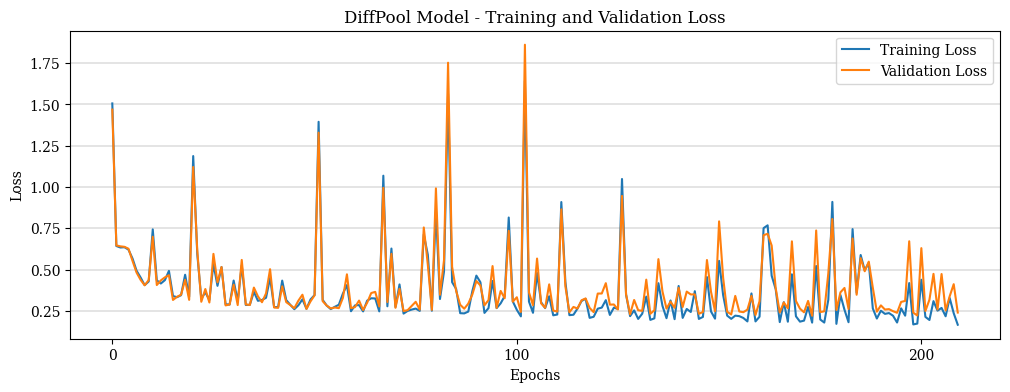

In [17]:
fig = plt.figure(figsize = (12,4))

# Generate a sequence of integers to represent the epoch numbers
epochs = range(0, cut_epoch)
 
# Plot and label the training and validation loss values
ax = plt.plot(epochs, training_loss[0:cut_epoch], label='Training Loss')
ax2 = plt.plot(epochs, validation_loss[0:cut_epoch], label='Validation Loss')
 
# Add all the text elements
hfont = {'fontname':'serif'}
font = font_manager.FontProperties(family='serif',
                                   weight='normal',
                                   style='normal')

plt.title('DiffPool Model - Training and Validation Loss', **hfont)
plt.xlabel('Epochs', **hfont)
plt.ylabel('Loss', **hfont)

 
# Set the tick locations
plt.xticks(np.arange(0, cut_epoch, 100), **hfont)
plt.yticks(**hfont)
 
# Display the plot
plt.legend(loc='upper right', prop = font)
plt.grid(axis = 'y', color = 'gray', linewidth = 0.3)
plt.rcParams['savefig.dpi']=300
#plt.savefig(f'{model_name}_plot_loss.png')
plt.show()

#### Plot Accuracy

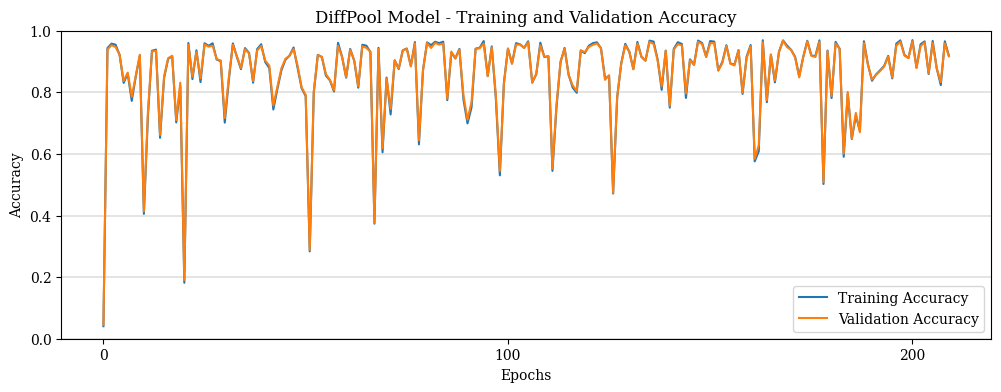

In [20]:
fig = plt.figure(figsize = (12,4))

# Generate a sequence of integers to represent the epoch numbers
epochs = range(0, cut_epoch)
 
# Plot and label the training and validation loss values
plt.plot(epochs, training_accuracy[0:cut_epoch], label='Training Accuracy')
plt.plot(epochs, validation_accuracy[0:cut_epoch], label='Validation Accuracy')
 
# Add all the text elements
hfont = {'fontname':'serif'}
font = font_manager.FontProperties(family='serif',
                                   weight='normal',
                                   style='normal')

plt.title('DiffPool Model - Training and Validation Accuracy', **hfont)
plt.xlabel('Epochs', **hfont)
plt.ylabel('Accuracy', **hfont)

# Set the tick locations
plt.xticks(np.arange(0, cut_epoch, 100), **hfont)
plt.yticks(**hfont)
plt.ylim(0,1)

# Display the plot
plt.legend(loc='lower right', prop = font)
plt.grid(axis = 'y', color = 'gray', linewidth = 0.3)
plt.rcParams['savefig.dpi']=300
#plt.savefig(f'{model_name}_plot_accuracy.png')
plt.show()

### Testing the Model

In [21]:
#Determine which state_dict to use for testing on the test dataset
state_dict_name = 'model_diffpool_alldata2_drop03_test_state_dict_epoch188.pt'
inference_loader = DenseDataLoader(dataset = test_dataset, batch_size=16, shuffle=True)

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DiffPool(in_channels=19, hidden_channels=32, n_classes=2).to(device)
model.load_state_dict(torch.load(state_dict_name))
model.eval()

DiffPool(
  (gnn1_pool): GNN(
    (conv1): DenseGCNConv(19, 32)
    (conv2): DenseGCNConv(32, 200)
  )
  (gnn1_embed): GNN(
    (conv1): DenseGCNConv(19, 32)
    (conv2): DenseGCNConv(32, 32)
  )
  (gnn2_pool): GNN(
    (conv1): DenseGCNConv(32, 32)
    (conv2): DenseGCNConv(32, 40)
  )
  (gnn2_embed): GNN(
    (conv1): DenseGCNConv(32, 32)
    (conv2): DenseGCNConv(32, 32)
  )
  (gnn3_pool): GNN(
    (conv1): DenseGCNConv(32, 32)
    (conv2): DenseGCNConv(32, 10)
  )
  (gnn3_embed): GNN(
    (conv1): DenseGCNConv(32, 32)
    (conv2): DenseGCNConv(32, 32)
  )
  (gnn4_pool): GNN(
    (conv1): DenseGCNConv(32, 32)
    (conv2): DenseGCNConv(32, 1)
  )
  (gnn4_embed): GNN(
    (conv1): DenseGCNConv(32, 32)
    (conv2): DenseGCNConv(32, 32)
  )
  (readout): JumpingKnowledge(cat)
  (lin1): Linear(in_features=256, out_features=32, bias=True)
  (bns): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin2): Linear(in_features=32, out_features=2, bias=True)
)

In [23]:
def inference_test(loader):
    model.eval()

    inf_loss_all = 0
    correct = 0

    predictions=[]
    ground_truth = []
    fitnesses = []
    

    for data in loader:
        data = data.to(device)
        output,_,_ = model(data.x, data.adj)
        
        # Compute Accuracy
        pred = output.max(dim=1)[1]

        predictions = predictions + pred.tolist()
        ground_truth = ground_truth + data.y.view(-1).tolist()
        fitnesses = fitnesses + data.fitness.tolist()
        
        correct += pred.eq(data.y.view(-1)).sum().item()

        # Compute Loss
        test_loss = F.nll_loss(output, data.y.view(-1))
        inf_loss_all += data.y.size(0) * test_loss.item()

    return correct / len(loader.dataset), inf_loss_all / len(loader.dataset), predictions, ground_truth, fitnesses

In [24]:
inf_acc, inf_loss, predictions, ground_truth, fitnesses = inference_test(inference_loader)


print(inf_acc)
print(inf_loss)

0.9620449264136328
0.0962140931588365


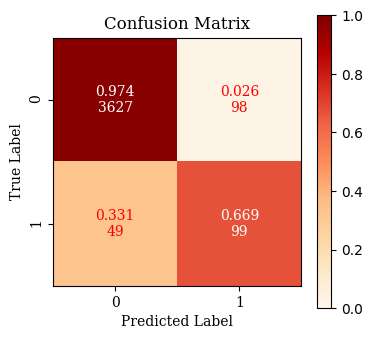

In [25]:
# Plot Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(ground_truth, predictions, labels=[0,1])
cm_norm = confusion_matrix(ground_truth, predictions, labels=[0,1], normalize='true')

#Manage fonts
hfont = {'fontname':'serif'}
font = font_manager.FontProperties(family='serif',
                                   weight='normal',
                                   style='normal')

classes = [0,1]
fig, ax = plt.subplots(figsize=(4,3.8))
cb = ax.imshow(cm_norm, cmap='OrRd', vmin = 0, vmax = 1)

plt.xticks(range(len(classes)), classes, **hfont)
plt.yticks(range(len(classes)), classes, rotation = 90, **hfont)

for i in range(len(classes)):
    for j in range(len(classes)):
        color='red' if cm_norm[j,i] < 0.5 else 'white'
        ax.annotate(f'{cm_norm[j,i]:.3f}\n{cm[j,i]}', (i,j), 
                    color=color, va='center', ha='center', **hfont)


plt.ylabel('True Label', **hfont)
plt.xlabel('Predicted Label', **hfont)
plt.title('Confusion Matrix', **hfont)

plt.colorbar(cb, ax=ax)

plt.rcParams['savefig.dpi']=300
#plt.savefig(f'{model_name}_plot_confusion_matrix.png', bbox_inches = 'tight')

plt.show()

In [26]:
# Compute performance metrics

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn+fp)
specificity

print('Accuracy: %.3f' % accuracy_score(ground_truth, predictions))
print('Precision: %.3f' % precision_score(ground_truth, predictions))
print('Recall: %.3f' % recall_score(ground_truth, predictions))
print('Specificity: %.3f' % specificity)
print('F1 Score: %.3f' % f1_score(ground_truth, predictions))

Accuracy: 0.962
Precision: 0.503
Recall: 0.669
Specificity: 0.974
F1 Score: 0.574


### Calculations for Assignment Matrix

In [27]:
fitness_bins_correct = []
fitness_bins_false = []

for index, fit in enumerate(fitnesses):
    if ground_truth[index] == predictions[index]:
        fitness_bins_correct.append(fit)

    else:
        fitness_bins_false.append(fit)

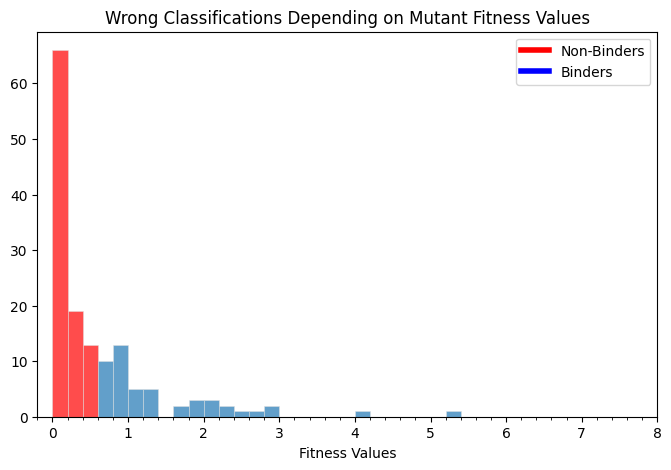

In [28]:
# Plot wrong classifications per fitness bin 

custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='blue', lw=4)]

fig, ax2 = plt.subplots(1,1, sharex=True, figsize=(8,5))

x_lim_down = 0
x_lim_up = 8
bin_size = 0.2
bins = np.arange(x_lim_down, x_lim_up+0.1, bin_size)

n, bins, patches = ax2.hist(fitness_bins_false, bins=bins, linewidth=0.5, alpha=0.7, edgecolor='#e0e0e0')
false_bins = n

patches[0].set_fc('red')
patches[1].set_fc('red')
patches[2].set_fc('red')

ax2.set_xlim(-0.2, 8)
ax2.legend(custom_lines, ['Non-Binders', 'Binders'])
ax2.xaxis.set_minor_locator(MultipleLocator(0.2))

ax2.set_title('Wrong Classifications Depending on Mutant Fitness Values')
plt.xlabel('Fitness Values', fontsize=10)
plt.show()

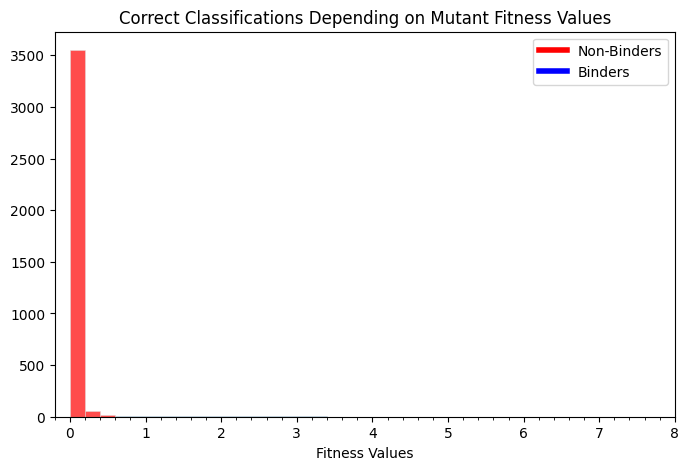

In [29]:
# Plot Correct Classifications per fitness bin

custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='blue', lw=4)]

fig, ax2 = plt.subplots(1,1, sharex=True, figsize=(8,5))

x_lim_down = 0
x_lim_up = 8
bin_size = 0.2
bins = np.arange(x_lim_down, x_lim_up+0.1, bin_size)

n, bins, patches = ax2.hist(fitness_bins_correct, bins=bins, linewidth=0.5, alpha=0.7, edgecolor='#e0e0e0')
correct_bins = n

patches[0].set_fc('red')
patches[1].set_fc('red')
patches[2].set_fc('red')

ax2.set_xlim(-0.2, 8)
ax2.legend(custom_lines, ['Non-Binders', 'Binders'])
ax2.xaxis.set_minor_locator(MultipleLocator(0.2))

ax2.set_title('Correct Classifications Depending on Mutant Fitness Values')
plt.xlabel('Fitness Values', fontsize=10)
plt.show()

In [30]:
total_bins = correct_bins + false_bins
ratio_bins = correct_bins / total_bins
ratio_bins

/tmp/ipykernel_337482/621854859.py:2: RuntimeWarning: invalid value encountered in divide
  ratio_bins = correct_bins / total_bins


array([0.98175283, 0.74666667, 0.60606061, 0.52380952, 0.43478261,
       0.5       , 0.64285714, 1.        , 0.81818182, 0.75      ,
       0.66666667, 0.66666667, 0.8       , 0.85714286, 0.66666667,
       1.        , 1.        , 1.        ,        nan, 1.        ,
       0.66666667,        nan,        nan,        nan,        nan,
       1.        , 0.        , 1.        ,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan])

In [31]:
assign_matrix = np.array([correct_bins.tolist(), false_bins.tolist()], dtype=int)
assign_matrix

array([[3551,   56,   20,   11,   10,    5,    9,    9,    9,    9,    6,
           4,    4,    6,    4,    3,    4,    1,    0,    1,    2,    0,
           0,    0,    0,    1,    0,    1,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [  66,   19,   13,   10,   13,    5,    5,    0,    2,    3,    3,
           2,    1,    1,    2,    0,    0,    0,    0,    0,    1,    0,
           0,    0,    0,    0,    1,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]])

In [32]:
sum_matrix = np.sum(assign_matrix, 0).tolist()

In [33]:
percentages = np.zeros((2, assign_matrix.shape[1]))
for column in range(assign_matrix.shape[1]):
    for row in range(assign_matrix.shape[0]):
        percentages[row, column] = assign_matrix[row, column] / sum_matrix[column]

percentages


/tmp/ipykernel_337482/3115980556.py:4: RuntimeWarning: invalid value encountered in long_scalars
  percentages[row, column] = assign_matrix[row, column] / sum_matrix[column]


array([[0.98175283, 0.74666667, 0.60606061, 0.52380952, 0.43478261,
        0.5       , 0.64285714, 1.        , 0.81818182, 0.75      ,
        0.66666667, 0.66666667, 0.8       , 0.85714286, 0.66666667,
        1.        , 1.        , 1.        ,        nan, 1.        ,
        0.66666667,        nan,        nan,        nan,        nan,
        1.        , 0.        , 1.        ,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan],
       [0.01824717, 0.25333333, 0.39393939, 0.47619048, 0.56521739,
        0.5       , 0.35714286, 0.        , 0.18181818, 0.25      ,
        0.33333333, 0.33333333, 0.2       , 0.14285714, 0.33333333,
        0.        , 0.        , 0.        ,        nan, 0.        ,
        0.33333333,        nan,        nan,        nan,        nan,
        0.        , 1.        , 0.        ,        nan,        nan,
               nan,        nan,        nan,    

In [34]:
# Cut off some of the last nan's
percentages = percentages[:, 0:28]
percentages = np.around(percentages, 3)
percentages

array([[0.982, 0.747, 0.606, 0.524, 0.435, 0.5  , 0.643, 1.   , 0.818,
        0.75 , 0.667, 0.667, 0.8  , 0.857, 0.667, 1.   , 1.   , 1.   ,
          nan, 1.   , 0.667,   nan,   nan,   nan,   nan, 1.   , 0.   ,
        1.   ],
       [0.018, 0.253, 0.394, 0.476, 0.565, 0.5  , 0.357, 0.   , 0.182,
        0.25 , 0.333, 0.333, 0.2  , 0.143, 0.333, 0.   , 0.   , 0.   ,
          nan, 0.   , 0.333,   nan,   nan,   nan,   nan, 0.   , 1.   ,
        0.   ]])

In [35]:
bins = bins[0:28]
bins= np.around(bins, 1)
bins

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
       2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ,
       5.2, 5.4])

### Assignment Matrix

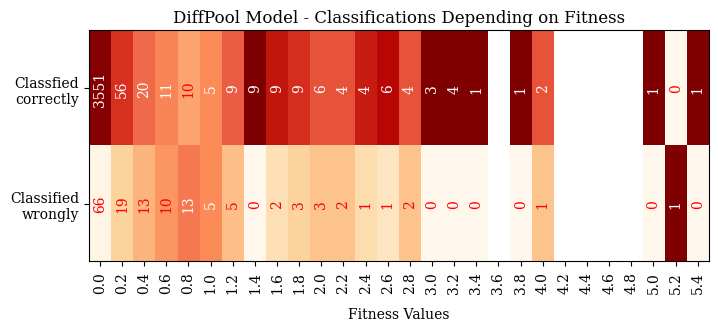

In [37]:
cm = confusion_matrix(ground_truth, predictions, labels=[0,1])
cm_norm = confusion_matrix(ground_truth, predictions, labels=[0,1], normalize='true')

#Manage fonts
hfont = {'fontname':'serif'}
font = font_manager.FontProperties(family='serif',
                                   weight='normal',
                                   style='normal')

classes = ['Classfied\ncorrectly','Classified\nwrongly']
fig, ax = plt.subplots(figsize=(8,3))
cb = ax.imshow(percentages[0:30], cmap='OrRd', aspect = 'auto')

plt.xticks(range(len(bins)),bins, rotation = 90, **hfont)
plt.yticks(range(len(classes)), classes, **hfont)

for i in range(len(classes)):
    for j in range(len(bins)):
        color='red' if percentages[i,j] < 0.5 else 'white'
        ax.annotate(f'{assign_matrix[i,j]}', (j,i), 
                    color=color, va='center', ha='center', rotation=90 ,**hfont)


plt.xlabel('Fitness Values', labelpad = 10, **hfont)
plt.title('DiffPool Model - Classifications Depending on Fitness', **hfont)

#plt.colorbar(cb, ax=ax, location='top', orientation = 'horizontal', fraction = 0.1 )

plt.rcParams['savefig.dpi']=300
#plt.savefig(f'{model_name}_plot_assignment_matrix.png', bbox_inches = 'tight')

plt.show()